<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_09_auto_ml_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning - Finance 20200712

In [ ]:
COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v3'

In [ ]:
if COLAB:
  !pip install -U imblearn
  !pip install -U xgboost

  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects
  
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .
  !cp dl-projects/plot* .

Requirement already up-to-date: imblearn in /usr/local/lib/python3.6/dist-packages (0.0)
     |████████████████████████████████| 127.6MB 30kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Cloning into 'dl-projects'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 2072 (delta 54), reused 25 (delta 10), pack-reused 1977
Receiving objects: 100% (2072/2072), 79.15 MiB | 36.46 MiB/s, done.
Resolving deltas: 100% (1279/1279), done.


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 
import matplotlib
import sys
import gc
import pylab as pl
import xgboost as xgb

from scipy import stats
from collections import Counter
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

import featuretools as ft
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, make_scorer, recall_score, roc_curve, mean_squared_error, accuracy_score, average_precision_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     AllKNN,
                                     NearMiss,
                                     OneSidedSelection,
                                     EditedNearestNeighbours)
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN 
from collections import Counter
from dateutil.relativedelta import relativedelta

from utils import feature_selection, plot_feature_importances
from plot import plot_correlation_matrix, plot_labeled_scatter

from IPython.display import display

from preprocess import *

np.set_printoptions(threshold=sys.maxsize)
plt.style.use('fivethirtyeight')
sns.set(style="ticks")

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [ ]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("../datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.ft"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 4948M
-rw------- 1 root root   17M Jul  6 14:06 feature_matrix_2020_apr.ft
-rw------- 1 root root   17M Jul  6 14:06 feature_matrix_2020_apr_orig.pkl
-rw------- 1 root root   17M Mar  1 05:47 feature_matrix_2020_feb.ft
-rw------- 1 root root   17M Mar  1 05:39 feature_matrix_2020_jan.ft
-rw------- 1 root root   17M Jul  7 13:52 feature_matrix_2020_jul.ft
-rw------- 1 root root   17M Jul  7 13:52 feature_matrix_2020_jul_orig.pkl
-rw------- 1 root root   17M Jul  5 07:30 feature_matrix_2020_jun.ft
-rw------- 1 root root   17M Jul  5 07:30 feature_matrix_2020_jun_orig.pkl
-rw------- 1 root root   17M Jul  6 13:56 feature_matrix_2020_mar.ft
-rw------- 1 root root   17M Jul  6 13:56 feature_matrix_2020_mar_orig.pkl
-rw------- 1 root root   17M Jul  7 13:40 feature_matrix_2020_may.ft
-rw------- 1 root root   17M Jul  7 13:40 feature_matrix_2020_may_orig.pkl
-rw------- 1 root root 2454M Jan 12  2020 feature_matrix_d2_v2.ft
-rw------- 1 root root 1585M Jan 12  2020 feature_matrix_d2_v3.f

In [ ]:
# Read the data
data = pd.read_feather(DATASET)
origin_data = format_tabular(ORIGIN_DATASET)

In [ ]:
# Display null rows
# data[data.isna().any(axis=1)]

## Add new data

In [ ]:
data.shape

(959893, 217)

In [ ]:
jan_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_jan.ft")
feb_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_feb.ft")
mar_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_mar.ft")
apr_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_apr.ft")
may_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_may.ft")
jun_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_jun.ft")
jul_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_jul.ft")

In [ ]:
new_data = data.append(jan_2020[data.columns],ignore_index=True)
new_data = new_data.append(feb_2020[data.columns],ignore_index=True)
new_data = new_data.append(mar_2020[data.columns],ignore_index=True)
new_data = new_data.append(apr_2020[data.columns],ignore_index=True)
new_data = new_data.append(may_2020[data.columns],ignore_index=True)
new_data = new_data.append(jun_2020[data.columns],ignore_index=True)
new_data = new_data.append(jul_2020[data.columns],ignore_index=True)
new_data.shape 

(1029893, 217)

In [ ]:
data = new_data
data.shape

(1029893, 217)

In [ ]:
data.isna().sum().sort_values(ascending=False)

CUM_SUM(SKEW(Results.TotalStrike))           7685
CUM_MEAN(TREND(Results.DrawNo, DrawDate))    7685
TREND(Results.CUM_SUM(DrawNo), DrawDate)     7685
TREND(Results.CUM_SUM(LuckyNo), DrawDate)    7685
CUM_SUM(SKEW(Results.LuckyNo))               7685
                                             ... 
CUM_SUM(MIN(Results.DrawNo))                    0
NUM_UNIQUE(Results.DAY(DrawDate))               0
NUM_UNIQUE(Results.MONTH(DrawDate))             0
SUM(Results.PERCENTILE(LuckyNo))                0
NumberId                                        0
Length: 217, dtype: int64

In [ ]:
#display(data.head(10).T)

## Exploratory Data Analysis

### View data

In [ ]:
# Feature matrix
feature_matrix = data.drop(columns=['NumberId', 'month', 'year'])

In [ ]:
# Sort data
feature_matrix.sort_values(by=['time', 'MAX(Results.LuckyNo)'], inplace=True)
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1029893 entries, 7020 to 1026411
Columns: 214 entries, time to LAST(Results.PrizeType)_Prize
dtypes: datetime64[ns](1), float64(155), int64(56), uint8(2)
memory usage: 1.6 GB


In [ ]:
print('Distribution')
print(feature_matrix['Label'].value_counts())
print()
print('Positive: ' + str(feature_matrix['Label'].value_counts()[0]) + ' which is ', round(feature_matrix['Label'].value_counts()[0]/len(feature_matrix) * 100,2), '% of the dataset')
print('Negative: ' + str(feature_matrix['Label'].value_counts()[1]) + ' which is ', round(feature_matrix['Label'].value_counts()[1]/len(feature_matrix) * 100,2), '% of the dataset')

Distribution
0    996848
1     33045
Name: Label, dtype: int64

Positive: 996848 which is  96.79 % of the dataset
Negative: 33045 which is  3.21 % of the dataset


In [ ]:
feature_matrix.isna().sum().sort_values(ascending=False)

SKEW(Results.TIME_SINCE_PREVIOUS(DrawDate))               7685
CUM_MEAN(TREND(Results.LuckyNo, DrawDate))                7685
TREND(Results.TIME_SINCE_PREVIOUS(DrawDate), DrawDate)    7685
TREND(Results.CUM_MEAN(TotalStrike), DrawDate)            7685
TREND(Results.CUM_SUM(LuckyNo), DrawDate)                 7685
                                                          ... 
CUM_SUM(MIN(Results.DrawNo))                                 0
NUM_UNIQUE(Results.DAY(DrawDate))                            0
NUM_UNIQUE(Results.MONTH(DrawDate))                          0
SUM(Results.PERCENTILE(LuckyNo))                             0
time                                                         0
Length: 214, dtype: int64

### Feature Selection

In [ ]:
# Fill all NaN with 0
feature_matrix = feature_matrix.fillna(0)

In [ ]:
feature_matrix.shape

(1029893, 214)

In [ ]:
# With feature selection
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'TotalStrike', 'Label']))

# Without feature selection
# feature_matrix_selection = feature_matrix.drop(columns = ['time', 'TotalStrike', 'Label'])

Original shape:  (1029893, 211)
0 missing columns with threshold: 90.
41 zero variance columns.
109 collinear columns removed with threshold: 0.95.
Total columns removed:  150
Shape after feature selection: (1029893, 61).


In [ ]:
feature_matrix_selection.shape, feature_matrix_selection.columns

((1029893, 61),
 Index(['STD(Results.DrawNo)', 'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)',
        'MIN(Results.DrawNo)', 'MEAN(Results.DrawNo)', 'SKEW(Results.DrawNo)',
        'AVG_TIME_BETWEEN(Results.DrawDate)', 'COUNT(Results)',
        'SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
        'TREND(Results.DrawNo, DrawDate)', 'MONTH(first_Results_time)',
        'DAY(first_Results_time)', 'TIME_SINCE(first_Results_time)',
        'TIME_SINCE_PREVIOUS(first_Results_time)',
        'STD(Results.PERCENTILE(DrawNo))',
        'STD(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'STD(Results.CUM_SUM(DrawNo))', 'STD(Results.CUM_MEAN(LuckyNo))',
        'MAX(Results.PERCENTILE(DrawNo))',
        'MAX(Results.PERCENTILE(TotalStrike))',
        'MAX(Results.CUM_MEAN(LuckyNo))',
        'MIN(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'MIN(Results.CUM_SUM(DrawNo))', 'MIN(Results.CUM_MEAN(LuckyNo))',
        'MODE(Results.MONTH(DrawDate))', 'MODE(Results.DAY(DrawDate))',
        'MEA

In [ ]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['TotalStrike'] = feature_matrix['TotalStrike']
feature_matrix_selection['Label'] = feature_matrix['Label']

In [ ]:
feature_matrix_selection.shape

(1029893, 64)

## Modeling

In [ ]:
def recall_optim(y_true, y_pred):
    """Make a scoring function that improves specificity while identifying all strikes
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Recall will be worth a greater value than specificity
    rec = recall_score(y_true, y_pred) * 0.8 
    spe = conf_matrix[0,0]/conf_matrix[0,:].sum() * 0.2 
    
    # Imperfect recalls will lose a penalty
    # This means the best results will have perfect recalls and compete for specificity
    if rec < 0.8:
        rec -= 0.2
    return rec + spe 

# Make a scoring callable from recall_score
recall = make_scorer(recall_score)

# DataFrame to store classifier performance
performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity', 'Optimize'])

def to_labels(pos_probs, threshold):
    """Apply threshold to positive probabilities to create labels.
    """
    return (pos_probs >= threshold).astype('int')
 

def score_optimization(dt, feature_matrix, clf, params, X_train, 
                       y_train, X_test, y_test, skip_grid_search_cv=False,
                       optimized_scorer=False):
    """Find the optimized classifier.
    """
    if not skip_grid_search_cv:
      print("\nFinding the optimized classifier...")

      # Load GridSearchCV
      # search = GridSearchCV(
      search = RandomizedSearchCV(
            estimator=clf,
            #param_grid=params,
            param_distributions=params,
            n_jobs=4,
            scoring=optimize  # Use custom scorer
      )

      # Train search object
      search.fit(X_train, y_train)

      # Heading
      print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)

      # Extract best estimator
      best = search.best_estimator_
      print('Best parameters: \n\n',search.best_params_,'\n')
    
    else:
      print("\nUse the passed in classifier...\n")
      best = clf

    # Cross-validate on the train data
    if not skip_grid_search_cv: 
      print("TRAIN GROUP")
      #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
      cv = 3
      if not optimized_scorer:
        print('\nUse default scorer')
        train_cv = cross_val_score(
                                  n_jobs=4,
                                  X=X_train, 
                                  y=y_train, 
                                  estimator=best, 
                                  scoring=recall,
                                  cv=cv)
      else:
        print('\nUse optimized scorer')
        train_cv = cross_val_score(
                                  n_jobs=4,
                                  X=X_train, 
                                  y=y_train, 
                                  estimator=best, 
                                  #scoring=optimize,
                                  scoring='roc_auc',
                                  #scoring=geo_mean_scorer,
                                  cv=cv)

      print("\nCross-validation recall scores:",train_cv)
      print("Mean recall score:",train_cv.mean())
      print('Mean G-Mean: %.3f (%.3f)' % (np.mean(train_cv), np.std(train_cv)))
    else:
      train_cv = np.zeros(3)

    # Now predict on the test group
    print("\nTEST GROUP")
    y_pred = best.fit(X_train, y_train).predict(X_test)
    # y_pred = best.fit(X_train, y_train,
    #                   eval_set=[(X_test, y_test)],
    #                   eval_metric='auc',
    #                   early_stopping_rounds=10,
    #                   verbose=True
    #                   ).predict(X_test)

    # keep probabilities for the positive outcome only
    probas = best.predict_proba(X_test)[:, 1]
    
    # define thresholds
    thresholds = np.arange(0, 1, 0.001)

    # evaluate each threshold
    scores = [f1_score(y_test, to_labels(probas, t)) for t in thresholds]

    # get best threshold
    ix = np.argmax(scores)
    print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

    # print recall
    print("\nRecall:",recall_score(y_test,y_pred))

    # Get imbalanced classification report
    print(classification_report_imbalanced(y_test, y_pred))

    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()

    # Store results
    performance.loc[clf.__class__.__name__+'_optimize',:] = [
        train_cv.mean(),
        recall_score(y_test,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum(),
        recall_optim(y_test,y_pred)
    ]
    # Look at the parameters for the top best scores
    if not skip_grid_search_cv:
      display(pd.DataFrame(search.cv_results_).iloc[:,4:].sort_values(by='rank_test_score').head())
    display(performance)

    # Additionl info
    print('\n\nAdditional Info')
    print('='*40)
    positive = np.where((y_pred==1))
    print(f'Total predicted to be positive: {len(positive[0])} \n')

    pred = np.where((y_pred==1))
    all_preds = pred[0]

    # Total predicted matches
    print('First 23 matches')
    print(23, all_preds[0:23])
    print(f'\n{probas[all_preds[0:23]]}\n') 

    print("\nTop 23 Probable Matches")
    #print('probas', probas)
    topN = np.argpartition(probas, -23)[-23:]
    print(f'\n{topN}\n')          # Top N most high probability numbers
    print(f'\n{probas[topN]}\n')  # Top N probability

    # Check for 2 to 3 digits range 
    print('\n2 To 3 Digits\n')
    idx_range = np.where((all_preds < 1000) & (all_preds >= 10))
    #print(idx_range)
    range_numbers = all_preds[idx_range]
    print(len(range_numbers), range_numbers)
    print(f'\n{probas[range_numbers]}\n') 


    # 2 to 3 Digits > Average Probas
    print('\n2 To 3 Digits Average Proba\n')
    avg_proba = np.average(probas[range_numbers])
    print(f'Average proba {avg_proba}\n')
    idx_avg_proba = np.where(probas > avg_proba) 
    print(len(idx_avg_proba[0]), idx_avg_proba[0])

    # 2 to 3 Digits > All Average Probas
    print('\n\nAll Average Proba\n')
    all_avg_proba = np.average(probas[all_preds])
    print(f'All average probas {all_avg_proba}\n')
    idx_all_avg_proba = np.where(probas > all_avg_proba) 
    print(len(idx_all_avg_proba[0]), idx_all_avg_proba[0])


    # All predicted matches
    print('\n\nAll Predictions\n')
    print(len(all_preds), all_preds)
    print()
    print(len(probas[all_preds]), probas[all_preds])
    
    #print('Debug')
    #print(pred)
    
    if len(positive[0]) > 0:
    
      # Matching draws
      print('\nMatched draws')
      md = np.where((y_pred==1) & (y_test==1))
      print(f"Count: {len(md[0])}, Index: {md}")
      month_data = feature_matrix.loc[feature_matrix['time'] == dt]
      numbers = month_data.iloc[md[0]][['MAX(Results.LuckyNo)']]

      print('\n\nTop 23 Possibility')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(topN))].head(23))  
      
      print('\n\nFirst 23 Numbers')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(pred[0][0:23]))].head(23))    
             

      print('\n\n2 To 3 Digits Numbers')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(range_numbers))].head(23))    
     

      print('\n\nAll matched')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(numbers['MAX(Results.LuckyNo)']))].head(100))    
                                                  
    else:
      print('No luck this month')  

    if len(range_numbers) >= 50:
      return False

    return True

In [ ]:
def remove_outliers(balanced, threshold=0.001, remove=True):
    """Removing Outliers from high-correlation features.
    """

    if not remove:
      return balanced

    bal_corr = balanced.corr()
    no_outliers=pd.DataFrame(balanced.copy())

    cols = bal_corr.Label.index[:-1]

    # For each feature correlated with Class...
    for col in cols:
        # If absolute correlation value is more than X percent...
        correlation = bal_corr.loc['Label',col]

        if np.absolute(correlation) > threshold:
          # Separate the classes of the high-correlation column
          nonstrikes = no_outliers.loc[no_outliers.Label==0,col]
          strikes = no_outliers.loc[no_outliers.Label==1,col]

          # Identify the 25th and 75th quartiles
          all_values = no_outliers.loc[:,col]
          q25, q75 = np.percentile(all_values, 25), np.percentile(all_values, 75)
          # Get the inter quartile range
          iqr = q75 - q25
          # Smaller cutoffs will remove more outliers
          cutoff = iqr * 7
          # Set the bounds of the desired portion to keep
          lower, upper = q25 - cutoff, q75 + cutoff
          
          # If positively correlated...
          # Drop nonstrikes above upper bound, and strikes below lower bound
          if correlation > 0: 
              no_outliers.drop(index=nonstrikes[nonstrikes>upper].index,inplace=True)
              no_outliers.drop(index=strikes[strikes<lower].index,inplace=True)
          
          # If negatively correlated...
          # Drop non strikes below lower bound, and strikes above upper bound
          elif correlation < 0: 
              no_outliers.drop(index=nonstrikes[nonstrikes<lower].index,inplace=True)
              no_outliers.drop(index=strikes[strikes>upper].index,inplace=True)
        
    print('\nData shape before removing outliers:', balanced.shape)
    print('\nCounts of strikes VS non-strikes in previous data:')
    print(balanced.Label.value_counts())
    print('-'*40)
    print('-'*40)
    print('\nData shape after removing outliers:', no_outliers.shape)
    print('\nCounts of strikes VS non-strikes in new data:')
    print(no_outliers.Label.value_counts())

    # no_outliers.iloc[:,:-1].boxplot(rot=90,figsize=(16,4))
    # plt.title('Distributions with Less Outliers', fontsize=17)
    # plt.show()
    
    no_outliers.reset_index(drop=True, inplace=True)
    return no_outliers


def filter_features(no_outliers, threshold=0.001):
    """Feature selection.
    """
    feat_sel = pd.DataFrame(no_outliers.copy())

    # Feature Selection based on correlation with label
    print('\nData shape before feature selection:', feat_sel.shape)
    print('\nCounts of strikes vs non-strikes before feature selection:')
    print(feat_sel.Label.value_counts())
    print('-'*40)

    # Correlation matrix after removing outliers
    new_corr = feat_sel.corr()

    for col in new_corr.Label.index[:-1]:
        # Pick desired cutoff for dropping features. In absolute-value terms.
        if np.absolute(new_corr.loc['Label',col]) < threshold:
            # Drop the feature if correlation is below cutoff
            feat_sel.drop(columns=col,inplace=True)

    print('-'*40)
    print('\nData shape after feature selection:', feat_sel.shape)
    print('\nCounts of strikes vs non-strikes in new data:')
    print(feat_sel.Label.value_counts())

    return feat_sel

def under_sampler(data, sample_size=20000, sampling=False):
    # Undersample model for efficiency and balance classes.

    X_train = data.drop('Label',1)
    y_train = data.Label

    if not sampling:
      return X_train, y_train

    # After feature-selection, X_test needs to include only the same features as X_train
    # cols = X_train.columns
    # X_test = X_test[cols]

    # Undersample and balance classes
    X_train, y_train = RandomUnderSampler(sampling_strategy={1:sample_size,0:sample_size}).fit_resample(X_train,y_train)

    print('\nX_train shape after reduction:', X_train.shape)
    print('\nCounts of strikes VS non-strikes in y_train:')
    print(np.unique(y_train, return_counts=True))

    return X_train, y_train

In [ ]:
def gen_train_test_set(dt, feature_matrix, file_prefix='data'): 
    
    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['time'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['time'] < dt, 'Label']

    # Features
    X_train = feature_matrix[feature_matrix['time'] < dt].drop(columns = ['NumberId', 'time', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['time'] == dt].drop(columns = ['NumberId', 'time', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    feature_names = list(X_train.columns)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))

    # Join the train data
    train = X_train.join(train_labels)

    print('Data shape before balancing:', train.shape)
    print('\nCounts of strikes vs non-strikes in previous data:')
    print(train.Label.value_counts())
    print('-'*40)

    # sklearn pipeline
    pipeline = make_pipeline(
        SimpleImputer(strategy = 'constant', fill_value=0),
        StandardScaler())
    
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)

    # imblearn pipeline
    imb_pipeline = make_pipeline_imb(
          # NearMiss(version=3, n_neighbors_ver3=3, n_jobs=4)
          # SMOTE(sampling_strategy='minority',random_state=42, n_jobs=4)
          # ADASYN(sampling_strategy='minority',random_state=42, n_jobs=4)
          # OneSidedSelection(n_neighbors=1, n_seeds_S=200, random_state=42, n_jobs=4)
          SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    )
     
    # Balance the data
    print('\nNo balancing')
    X_bal = pd.DataFrame(X_train,columns=feature_names)
    y_bal = pd.DataFrame(y_train,columns=['Label'])

    balanced = X_bal.join(y_bal)

    # print('-'*40)
    print('Data shape after balancing:',balanced.shape)
    print('\nCounts of strikes VS non-strikes in new data:')
    print(balanced.Label.value_counts())

    # Remove high correlation outliers
    no_outliers = remove_outliers(balanced, remove=False)
   
    # Remove features with low correlation
    remove_features = True
    if remove_features:
      print('\nFiltering features')
      features_selected = filter_features(no_outliers)
    else:
      print('\nNO filtering')
      features_selected = no_outliers 

    columns_selected = features_selected.drop('Label',1).columns

    # Under sampling
    X_train, y_train = under_sampler(features_selected, sampling=False) 
    X_train = pd.DataFrame(X_train,columns=columns_selected)
    y_train = pd.DataFrame(y_train,columns=['Label'])

    # For X_test, now only use the selected features
    X_test = pd.DataFrame(X_test,columns=feature_names)
    X_test = X_test[columns_selected]
    y_test = pd.DataFrame(y_test,columns=['Label'])

    #print(X_train.describe())
    #return

    # Save data
    # print(X_train.head(10))
    # print(y_train.head(10)) 

    # print(X_test.head(10))
    # print(y_test.head(10)) 
    X_train.to_feather(DATASET_PATH/f"{file_prefix}_X_train.ft")
    y_train.to_feather(DATASET_PATH/f"{file_prefix}_y_train.ft")
   
    X_test.to_feather(DATASET_PATH/f"{file_prefix}_X_test.ft")
    y_test.to_feather(DATASET_PATH/f"{file_prefix}_y_test.ft")

    gc.collect()


In [ ]:
def model(dt, feature_matrix, file_prefix='data', class_weight=1.0, estimators=300, depth=3):
    """Predict for a particular month.
    """

    # Load train test
    X_train = pd.read_feather(DATASET_PATH/f"{file_prefix}_X_train.ft")
    y_train = pd.read_feather(DATASET_PATH/f"{file_prefix}_y_train.ft")
    X_test = pd.read_feather(DATASET_PATH/f"{file_prefix}_X_test.ft")
    y_test = pd.read_feather(DATASET_PATH/f"{file_prefix}_y_test.ft")

    print(f'\n-----------{dt}-----------------\n')

    # Reshape
    y_train = np.array(y_train).reshape((-1, ))
    y_test = np.array(y_test).reshape((-1, ))
    
    print('Data shape')
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    # print(X_train.describe())
    # return

    # Calculate hit ratio for xgboost classifier
    print("\nCalculating scale pos weight")
    counter = Counter(y_train)
    print(Counter(y_train))
    #scale_pos_weight = float(counter[0] / counter[1])
    scale_pos_weight = (float(counter[0] / counter[1])) * class_weight
    print(f"\nscale_pos_weight - {scale_pos_weight}\n")
    
     # Modeling
    eval_set=[(X_train, y_train), (X_test, y_test)]
    clf = xgb.XGBClassifier(
                    n_jobs=4, 
                    random_state=42,
                    objective='binary:logistic',
                    subsample=0.55, 
                    #n_estimators=300,
                    n_estimators=estimators,
                    #n_estimators=550,
                    min_child_weight=1,
                    #max_depth=3, 
                    max_depth=depth, 
                    learning_rate=0.007,
                    gamma=0.1, 
                    colsample_bytree=0.95,
                    tree_method='hist',
                    booster='dart',
                    scale_pos_weight=scale_pos_weight
                    #eval_metric='auc',
                    #eval_set=eval_set,
                    #early_stopping_rounds=10
                    )

    clf_params = clf.get_params()
    print(clf_params)

    # Set parameters
    #clf_params['max_depth'] = 10
    #clf.set_params(clf_params)

    # Parameters to compare
    weights = [i for i in range(1,36,1)]
    weights.append(scale_pos_weight)
    learn_params = {
        'n_estimators': [100, 300, 500, 800, 1000], 
        'max_depth': range(3,10,2),
        'min_child_weight': range(1,6,2),
        #'gamma':[i/10.0 for i in range(0,5)],
        'subsample':[i/100.0 for i in range(55,70,5)],
        'colsample_bytree':[i/100.0 for i in range(85,100,5)],
        #'learning_rate':[i/1000.0 for i in range(5,20,2)],
        'scale_pos_weight': weights
    }
    print(f'Parameter distribution: {learn_params}')
    
    # Test and validate
    ret_val = score_optimization(dt,
                       feature_matrix,
                       clf, 
                       learn_params,  
                       X_train, 
                       y_train, 
                       X_test, 
                       y_test, 
                       skip_grid_search_cv=True,
                       optimized_scorer=True)

    gc.collect()

    return ret_val

Training on 969893 observations.
Testing on 10000 observations.

Data shape before balancing: (969893, 62)

Counts of strikes vs non-strikes in previous data:
0    937508
1     32385
Name: Label, dtype: int64
----------------------------------------

NO balancing
Data shape after balancing: (969893, 62)

Counts of strikes VS non-strikes in new data:
0    937508
1     32385
Name: Label, dtype: int64

Filtering features

Data shape before feature selection: (969893, 62)

Counts of strikes vs non-strikes before feature selection:
0    937508
1     32385
Name: Label, dtype: int64
----------------------------------------
----------------------------------------

Data shape after feature selection: (969893, 36)

Counts of strikes vs non-strikes in new data:
0    937508
1     32385
Name: Label, dtype: int64
CPU times: user 13.4 s, sys: 382 ms, total: 13.8 s
Wall time: 14.4 s

-----------2020-02-01 00:00:00-----------------

Data shape
(969893, 35) (969893,) (10000, 35) (10000,)

Calculating s

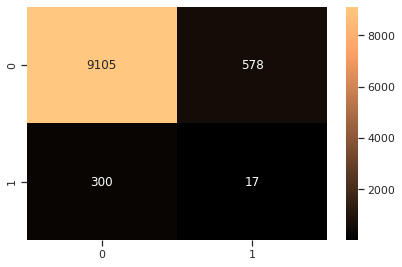

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0,0.0536278,0.940308,0.0309638




Additional Info
Total predicted to be positive: 595 

First 23 matches
23 [  0  13  19  28  29  33  35  42  52  54  72  92 129 131 151 163 185 193
 197 199 201 210 216]

[0.5053911  0.5023211  0.52201146 0.5008016  0.50219554 0.506599
 0.5057873  0.50578946 0.50611764 0.50479656 0.51033074 0.5035855
 0.5003583  0.501757   0.5037642  0.50157    0.50098574 0.50731844
 0.5051709  0.5038188  0.50012565 0.5095717  0.5053153 ]


Top 23 Probable Matches

[ 895 3111 4465 7836 1933 2479  925 4562 8938 1271 8981 1047 8690   19
 5301 5378 7455  950  823 6114 1949 5311  592]


[0.51466405 0.51983446 0.51778823 0.5161645  0.5158739  0.5161403
 0.51478326 0.52038753 0.52230006 0.52606606 0.5262078  0.52109915
 0.5256418  0.52201146 0.5270517  0.5206844  0.5272057  0.52723074
 0.5365867  0.52861756 0.5344132  0.5306532  0.53885746]


2 To 3 Digits

182 [ 13  19  28  29  33  35  42  52  54  72  92 129 131 151 163 185 193 197
 199 201 210 216 219 226 230 253 270 271 272 278 279 282 283 291 298 302
 3

In [ ]:
target_mth = pd.datetime(2020,2,1)
%time gen_train_test_set(target_mth, feature_matrix_selection, file_prefix='test')

#for (estimators, depth) in ((300,3), (500,6), (550,6), (600,6)):
for (estimators, depth) in ((300,3),):
  %time model(target_mth, feature_matrix_selection, file_prefix='test', estimators=estimators, depth=depth)